In [1]:
import os
import sys
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18, resnet50
from fastai.vision.models.unet import DynamicUnet


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(type(device))
use_colab = None

print(f"device: {device}")

<class 'torch.device'>
device: cuda


In [2]:
class Config:
    def __init__(self):
        self.epoch = 100
        self.batch_size = 64
        self.lr = 0.0001
        self.b1 = 0.5
        self.b2 = 0.999
        self.size = 256
        self.channels = 3
        self.latent_dim = 100 # size of generator input
config = Config()

class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)


def plot_image(img_batch, figsize=(8,3), cmap=None, title=None):
    if len(img_batch.shape)==3:
        img_batch = np.expand_dims(img_batch, axis=0)
    N = len(img_batch)
    fig = plt.figure(figsize=figsize)
    for i in range(N):
        img = img_batch[i]
#         img = np.transpose(img, [1,0,2])
        plt.subplot(1,N,i+1)
        plt.imshow(img, cmap=cmap)
    if title is not None:
        plt.title(f"{title}")
    plt.show()
    
def to_lab(l, ab, channels_first=True):
    if channels_first:
        if len(l.shape)==3:
            l = np.expand_dims(l, axis=1)
        lab = np.concatenate([l, ab], axis=1)
    else:
        if len(l.shape)==3:
            l = np.expand_dims(l, axis=3)
        lab = np.concatenate([l, ab], axis=3)
    return lab

def to_channel_first(arr):
    if len(arr.shape)==4:
        arr = np.transpose(arr, [0,3,2,1])
    else:
        arr = np.transpose(arr, [2,1,0])
    return arr

def to_channel_last(arr):
    if len(arr.shape)==4:
        arr = np.transpose(arr, [0,3,2,1])
    else:
        arr = np.transpose(arr, [2,1,0])
    return arr

def transform_expand_dim(axis):
    def fn(arr):
        arr = np.expand_dims(arr, axis=axis)
        return arr
    return fn

def transform_multiply(mul):
    def fn(arr):
        arr = arr * mul
        return arr
    return fn

def transform_divide(div):
    def fn(arr):
        arr = arr / div
        return arr
    return fn

def model_parameters_count(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params



In [3]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)

# coco_path = str(coco_path) + "/train_sample"
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [4]:
if use_colab == True:
    path = coco_path
else:
    path = "input"
    
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
print(len(paths))
# paths_subset = np.random.choice(paths, 21837, replace=False) # choosing 10000 images randomly
# rand_idxs = np.random.permutation(21837)
# train_idxs = rand_idxs[:1000] # choosing the first 8000 as training set
# val_idxs = rand_idxs[19500:20000] # choosing last 2000 as validation set
# test_idxs = rand_idxs[21000:]

paths_subset = np.random.choice(paths, 21837, replace=False) # choosing 10000 images randomly
rand_idxs = np.random.permutation(21837)
train_idxs = rand_idxs[:18000] # choosing the first 8000 as training set
val_idxs = rand_idxs[18000:20000] # choosing last 2000 as validation set
test_idxs = rand_idxs[21000:]

train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
test_paths = paths_subset[test_idxs]

print(len(train_paths), len(val_paths), len(test_paths))
print(f"paths_subset: {paths_subset}\n")
print(f" rand_idxs: {rand_idxs}\n")
print(f" train_paths: {train_paths}\n")

21837
18000 2000 837
paths_subset: ['/home/nol/.fastai/data/coco_sample/train_sample/000000231401.jpg'
 '/home/nol/.fastai/data/coco_sample/train_sample/000000353507.jpg'
 '/home/nol/.fastai/data/coco_sample/train_sample/000000467177.jpg' ...
 '/home/nol/.fastai/data/coco_sample/train_sample/000000269689.jpg'
 '/home/nol/.fastai/data/coco_sample/train_sample/000000303768.jpg'
 '/home/nol/.fastai/data/coco_sample/train_sample/000000550273.jpg']

 rand_idxs: [ 7072  5729  7843 ...  6771 14954 15281]

 train_paths: ['/home/nol/.fastai/data/coco_sample/train_sample/000000175383.jpg'
 '/home/nol/.fastai/data/coco_sample/train_sample/000000363922.jpg'
 '/home/nol/.fastai/data/coco_sample/train_sample/000000073096.jpg' ...
 '/home/nol/.fastai/data/coco_sample/train_sample/000000544703.jpg'
 '/home/nol/.fastai/data/coco_sample/train_sample/000000443460.jpg'
 '/home/nol/.fastai/data/coco_sample/train_sample/000000124911.jpg']



In [5]:
import torchvision.transforms as T
SIZE = config.size
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  T.InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  T.InterpolationMode.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        return L, ab
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=32, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

def build_fastai_model(in_channels=1, out_channels=2, image_shape=(config.size, config.size)):
    model_body = create_body(resnet18(), n_in=in_channels, cut=-2)
    model = DynamicUnet(encoder=model_body, n_out=out_channels, img_size=image_shape)
    return model.to(device)


def pretrain_generator(net_G, train_dl, opt, criterion=nn.L1Loss(), epochs=20):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for x, y in tqdm(train_dl):
            L, ab = x.to(device), y.to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1)
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img.cpu())
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [6]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl)) 
# print(len(data[1])) # : 16
Ls, abs_ = data[0], data[1] # data[0]: l, data[1]: ab
print(Ls.shape, abs_.shape) # torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256]) [batch_size, n_channels, w, h]
print(len(train_dl), len(val_dl)) # 1125 125

pretrained = False

torch.Size([32, 1, 256, 256]) torch.Size([32, 2, 256, 256])
563 63


In [ ]:
net_G = build_fastai_model(in_channels=1, out_channels=2, image_shape=(SIZE,SIZE))
opt = torch.optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
pretrain_generator(net_G, train_dl, opt, criterion, 20)
pretrained = True
torch.save(net_G.state_dict(), "pretrained_res18-unet2.pt")

In [7]:
def train(model, loss_fn, optimizer, dataloader_train, device):
    # model = model.to(device)
    N = len(dataloader_train.dataset)
    n_batch = int(N / dataloader_train.batch_size)
    
    model.train()
    losses = []
    for batch, (x,y) in enumerate(dataloader_train):
        # print(f"x: {x} type: {type(x)}\ny: {y} \n")
        x = x.to(device).float()
        y = y.to(device).float()
        # print("test() x.shape", x.shape)
        pred = model(x)
        loss = loss_fn(pred, y)
        losses.append(loss.item())
        # Backpropagation.
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        
        sys.stdout.write(f"\rTrain: {batch+1}/{n_batch} loss:{loss}")
        sys.stdout.flush()
        # break
    avg_loss = np.mean(losses)
    return avg_loss

def test(model, loss_fn, dataloader_test, device):
    model = model.to(device)
    N = len(dataloader_test.dataset)
    n_batch = int(N / dataloader_test.batch_size)
    losses = []
    model.eval()
    with torch.no_grad():
        for batch, (x,y) in enumerate(dataloader_test):
            x,y = x.to(device).float(), y.to(device).float()
            
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            
            sys.stdout.write(f"\rTest: {batch+1}/{n_batch} loss_test:{loss}")
            sys.stdout.flush()
            # break
    avg_loss = np.mean(losses)
    return avg_loss

def predict(model, dataloader_test, device, num_batches=4):
    model = model.to(device)
    N = len(dataloader_test.dataset)
    n_batch = int(N / dataloader_test.batch_size)
    model.eval()
    y_actual = []
    y_pred = []
    inputs = []
    ys = []
    with torch.no_grad():
        for batch, (x,y) in enumerate(dataloader_test):
            x,y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            
            if device == torch.device("cuda"):
                y_actual.append(torch.squeeze(y.detach()))
                y_pred.append(torch.squeeze(pred.detach()))
            else:
                y_actual.append(np.squeeze(y.detach()))
                y_pred.append(np.squeeze(pred.detach()))
            inputs.append(x.detach())
            sys.stdout.write(f"\rPred: {batch+1}/{n_batch}")
            sys.stdout.flush()
            if batch+1 == num_batches:
                break
    y_actual = torch.cat(y_actual)
    y_pred = torch.cat(y_pred)
    inputs = torch.cat(inputs)

    return inputs, y_actual, y_pred #, ys


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        layer = [
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(512, 1, 4, 2, 1)
        ]
        self.model = nn.Sequential(*layer)
        
    def forward(self, x):
        return self.model(x)
    
    
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [9]:
model = build_fastai_model(in_channels=1, out_channels=2, image_shape=(SIZE,SIZE))
if pretrained == True:
    print("pre-train done.")
    model.load_state_dict(torch.load("pretrained_res18-unet2.pt", map_location=device))
    

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
loss_fn = nn.MSELoss()

losses_train = []
losses_test = []
plot_freq = 5


In [14]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = build_fastai_model(in_channels=1, out_channels=2, image_shape=(SIZE,SIZE))
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = Discriminator().to(self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data[0].to(self.device)
        self.ab = data[1].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [11]:
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()

In [12]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    ds_test = make_dataloaders(paths=test_paths, split='val')
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data[0].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                # log_results(loss_meter_dict) # function to print out the losses
                for loss_name, loss_meter in loss_meter_dict.items():
                    print(f"{loss_name}: {loss_meter.avg:.5f}")
                visualize(model, data, save=False)
                # x_pred, y_pred, y_hat_pred = predict(model, ds_test, device, num_batches=1)
                # real_imgs = lab_to_rgb(x_pred, y_pred)
                # fake_imgs = lab_to_rgb(x_pred, y_hat_pred)
                # fig = plt.figure(figsize=(15, 8))
                # for i in range(5):
                #     ax = plt.subplot(3, 5, i + 1)
                #     ax.imshow(x_pred[i][0].cpu(), cmap='gray')
                #     ax.axis("off")
                #     ax = plt.subplot(3, 5, i + 1 + 5)
                #     ax.imshow(fake_imgs[i])
                #     ax.axis("off")
                #     ax = plt.subplot(3, 5, i + 1 + 10)
                #     ax.imshow(real_imgs[i])
                #     ax.axis("off")
                # plt.show()
    torch.save(model.state_dict(), "gan.pt")

In [ ]:
net_G = build_fastai_model(1, 2, (256, 256))
net_G.load_state_dict(torch.load("pretrained_res18-unet2.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 20)

In [15]:
net_G = build_fastai_model(1, 2, (256, 256))
net_G.load_state_dict(torch.load("pretrained_res18-unet2.pt", map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("gan.pt",  map_location=device))

<All keys matched successfully>

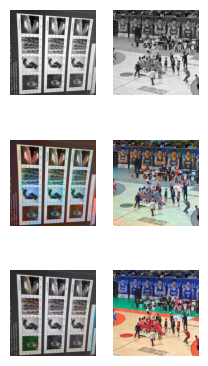

In [31]:
model.net_G.eval()
paths= [
    "/home/nol/woosuk/addColorToImg/images/test1.jpeg",
    "/home/nol/woosuk/addColorToImg/images/test2.jpeg"
]
my_photo_dl = make_dataloaders(batch_size=len(paths), paths=paths, split='val')
with torch.no_grad():
    data = next(iter(my_photo_dl))
    model.setup_input(data)
    model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    # print(fake_imgs)
    it = min(5, len(paths))
    for i in range(it):
        ax = plt.subplot(3, 2, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 2, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 2, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()



In [ ]:

ds_test = make_dataloaders(paths=test_paths, split='val')

for epoch in range(config.epoch):
    print(f"\nEpoch {epoch+1}/{config.epoch}\n")
    loss_train = train(model, loss_fn, optimizer, train_dl, device)
    losses_train.append(loss_train)
    print()
    loss_test = test(model, loss_fn, val_dl, device)
    losses_test.append(loss_test)
    print(f"\n{epoch}th epoch: train = {losses_train}, test = {losses_test}")
    if (epoch+1)%plot_freq == 0:
        torch.save(model.state_dict(), f"{epoch}th_main_parameters.pt")
        x_pred, y_pred, y_hat_pred = predict(model, ds_test, device, num_batches=1)
        real_imgs = lab_to_rgb(x_pred, y_pred)
        fake_imgs = lab_to_rgb(x_pred, y_hat_pred)
        fig = plt.figure(figsize=(15, 8))
        for i in range(5):
            ax = plt.subplot(3, 5, i + 1)
            ax.imshow(x_pred[i][0].cpu(), cmap='gray')
            ax.axis("off")
            ax = plt.subplot(3, 5, i + 1 + 5)
            ax.imshow(fake_imgs[i])
            ax.axis("off")
            ax = plt.subplot(3, 5, i + 1 + 10)
            ax.imshow(real_imgs[i])
            ax.axis("off")
        plt.show()
        
        plt.plot(losses_train, label="losses_train")
        plt.plot(losses_test, label="losses_test")
        plt.legend(loc="upper left")
        plt.show()
        # plt.savefig(f'/home/nol/woosuk/addColorToImg/res_imgs/res_epoch{epoch+1}.png')
